In [1]:
import numpy as np
import pandas as pd,os
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from scipy.stats import wilcoxon, friedmanchisquare, rankdata
import scikit_posthocs as sp
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
from library.utils import read_data

In [3]:
METRIC_TO_DROP = 'pr_rec_score' #pr_rec_score, matthews_corrcoef
ipf = pd.read_csv("Results/IPF.csv",header=[0,1,2],index_col=0)
ipf = ipf.drop(columns=['rboost_DT','rboost_NB'],level=1)
ipf = ipf.drop(columns=[METRIC_TO_DROP],level=2).droplevel(2,axis=1) 
ipf = ipf.drop(columns=['ens'],level=0) 
print(f"ipf:{ipf.shape}")

ipf:(32, 30)


In [ ]:
ihf = pd.read_csv("IHFilter_Final.csv",header=[0,1,2],index_col=0)
ihf = ihf.drop(columns=[METRIC_TO_DROP],level=2).droplevel(2,axis=1) 
ihf = ihf.drop(columns=['Spyder'],level=0) 
print(f"ihf:{ihf.shape}")

In [ ]:
clni = pd.read_csv("CLNI.csv",header=[0,1,2],index_col=0)
#clni = clni.drop(columns=[c[0] for c in clni.columns if 'ens' in c[0]],level=0)
clni = clni.drop(columns=[METRIC_TO_DROP],level=2).droplevel(2,axis=1) 
clni = clni.drop(columns=['Spyder'],level=0) 
print(f"clni:{clni.shape}")

In [ ]:
clni.columns

(384, 3)


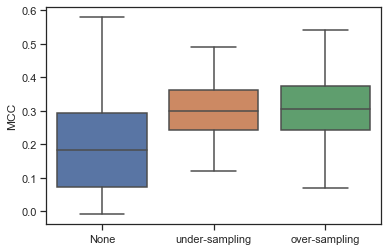

In [24]:
boo = ipf.stack().reset_index(drop=True)
tmp = pd.concat((boo[['None','rus','smote']],boo[['None','rus','smote']]),axis=0)
tmp.columns = ['None','under-sampling','over-sampling']
print(tmp.shape)
plt.ylabel("MCC")
fig = sns.boxplot(data=tmp);
fig.get_figure().savefig("figures/imb.eps",format='eps');

In [5]:
from library.utils import read_data
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
X,yn,yr = read_data('jruby-1.5.0.csv')
X = StandardScaler().fit_transform(X)
idx = yn==1
real = yr[idx]
TP = (yn==1) & (yr==1)
FP = (yn==1) & (yr==0)
print(TP.sum(),FP.sum())

C:\Users\Shihab\Anaconda3\envs\ml\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Shihab\Anaconda3\envs\ml\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Shihab\Anaconda3\envs\ml\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 

jruby-1.5.0.csv noise:0.218, imb:3.098,276,855, Shape:(1131, 65)
56 220


In [6]:
pca = PCA(n_components=2).fit(X)
Xp = pca.transform(X)
pca.explained_variance_ratio_

array([0.47032073, 0.09976393])

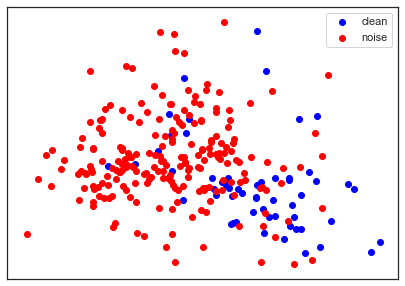

In [35]:
plt.figure(figsize=(7,5))
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.scatter(Xp[TP,0],Xp[TP,1],color='blue',label='clean');
plt.scatter(Xp[FP,0],Xp[FP,1],color='red',label='noise');
plt.legend();
form = 'pdf'
plt.savefig(f"figures/orig_pos.{form}",format=form);

<Figure size 432x288 with 0 Axes>

In [8]:
from sklearn.neighbors import KNeighborsClassifier
K = 5
Xnew,purity = [],[]
freq = np.bincount(yn)
print(freq)
knn = KNeighborsClassifier(n_neighbors=K).fit(X,yn)
dist,ind = knn.kneighbors()
pos_idx = np.argwhere(yn==1).reshape(-1)
print(ind.shape)
for i in range(freq.max()-freq.min()):
    idx = np.random.choice(pos_idx,size=(2,),replace=True)
    p1,p2 = X[idx[0]],X[idx[1]]
    v = (yr[idx[0]] + yr[idx[1]])/2
    a = np.random.uniform()
    x = a*p1 + (1-a)*p2
    Xnew.append(x)
    purity.append(v)
Xnew = np.array(Xnew)
purity = np.array(purity)
Xnew.shape,purity.shape

[855 276]
(1131, 5)


((579, 65), (579,))

(1710, 65)
[0.5050984  0.09372296]


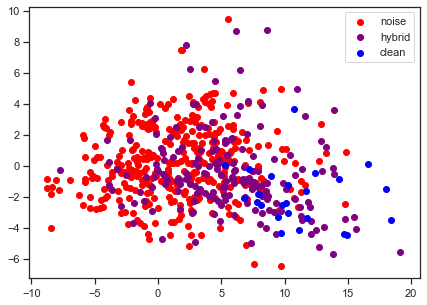

In [36]:
XX = np.vstack((X,Xnew))
print(XX.shape)
pca = PCA(n_components=2).fit(XX)
Xns = pca.transform(Xnew)
print(pca.explained_variance_ratio_)
plt.figure(figsize=(7,5))
plt.scatter(Xns[purity==0.0,0],Xns[purity==0.0,1],c='red',label='noise');
plt.scatter(Xns[purity==0.5,0],Xns[purity==0.5,1],c='purple',label='hybrid');
plt.scatter(Xns[purity==1.0,0],Xns[purity==1.0,1],c='blue',label='clean');
plt.legend();

form = 'pdf'
plt.savefig(f"figures/aft_smote.{form}",format=form);

In [15]:
(purity==0).sum(),(purity==0.5).sum(),(purity==1.0).sum()

(370, 185, 24)

## Under-sampling

In [ ]:
ipf.index